In [1]:
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## One-Hot Кодирование целевых классов

In [2]:
encoder = OneHotEncoder()
encoder.fit([[0], [1]])

# 0 - Опухоль
# 1 - Без опухоли

OneHotEncoder()

In [3]:
data = []  # Для хранения изображений
paths = []  # Для хранения путей к изображениям
result = []  # Для хранения закодированных результатов

# Перебор файлов в директории с помощью os.walk
for r, d, f in os.walk(r'Datasets/brain_tumor_dataset/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

# Обработка каждого пути к изображению
for path in paths:
    # Открытие изображения с использованием библиотеки PIL
    img = Image.open(path)

    # Изменение размера изображения до 128x128
    img = img.resize((128, 128))

    # Преобразование изображения в массив numpy
    img = np.array(img)

    # Проверка размера изображения и добавление его в соответствующие списки
    if (img.shape == (128, 128, 3)):
        data.append(np.array(img))
        # Добавление закодированного результата в список result
        result.append(encoder.transform([[0]]).toarray())

In [4]:
# Обновление списка результатов для изображений без опухоли
paths = []

# Перебор файлов в директории с изображениями без опухоли
for r, d, f in os.walk(r"Datasets/brain_tumor_dataset/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

# Обработка каждого пути к изображению без опухоли
for path in paths:
    # Открытие изображения с использованием библиотеки PIL
    img = Image.open(path)

    # Изменение размера изображения до 128x128
    img = img.resize((128, 128))

    # Преобразование изображения в массив numpy
    img = np.array(img)

    # Проверка размера изображения и добавление его в соответствующие списки
    if (img.shape == (128, 128, 3)):
        data.append(np.array(img))
        # Добавление закодированного результата (без опухоли) в список result
        result.append(encoder.transform([[1]]).toarray())

In [5]:
data = np.array(data)
data.shape

(139, 128, 128, 3)

In [6]:
result = np.array(result)
result = result.reshape(139, 2)

### Гистограмма распределения для опухоли и нормы

In [10]:
# Подсчет количества образцов с опухолью и без опухоли
tumor_count = np.sum(result[:, 0] == 1)
normal_count = np.sum(result[:, 1] == 1)

# Создание меток и количеств для столбчатой диаграммы
labels = ['Опухоль', 'Норма']
counts = [tumor_count, normal_count]

# Пример цветов, которые визуально приятны
colors = ['skyblue', 'lightcoral']

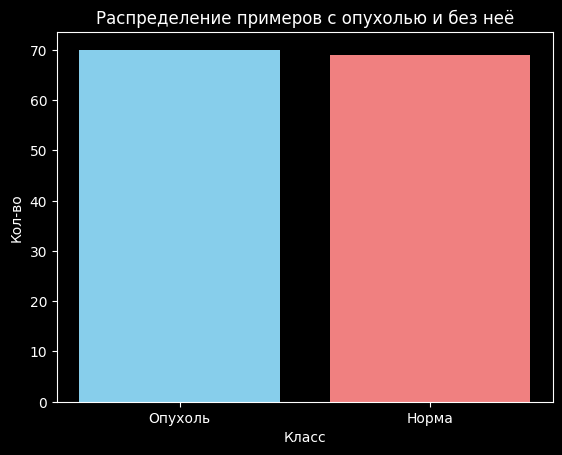

In [11]:
plt.bar(labels, counts, color=colors)
plt.title('Распределение примеров с опухолью и без неё')
plt.xlabel('Класс')
plt.ylabel('Кол-во')
plt.show()

### Круговая диаграмма

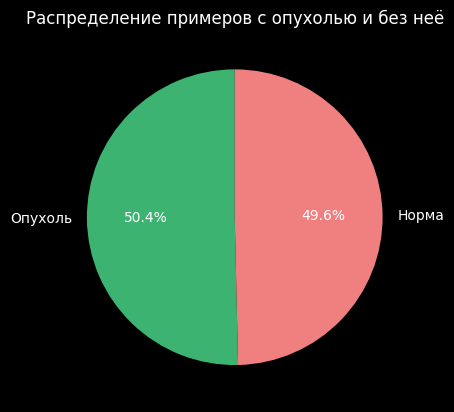

In [12]:
# Высчитываем процентики
total_samples = len(result)
tumor_percentage = (tumor_count / total_samples) * 100
normal_percentage = (normal_count / total_samples) * 100

labels = ['Опухоль', 'Норма']
counts = [tumor_percentage, normal_percentage]
colors = ['mediumseagreen', 'lightcoral']

plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Распределение примеров с опухолью и без неё')
plt.show()

In [13]:
x_train, x_test, y_train, y_test = train_test_split(data, result, test_size=0.2, shuffle=True, random_state=0)

# Соберем модель

In [14]:
# Создание последовательной модели нейронной сети
model = Sequential()

# Первый слой свертки с 32 фильтрами, размером ядра (2, 2) и входной формой (128, 128, 3)
model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding='Same'))
# Второй слой свертки с 32 фильтрами, размером ядра (2, 2), активацией ReLU и padding='Same'
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='Same'))

# Нормализация по батчам
model.add(BatchNormalization())
# Пуллинг слой с размером пула (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой Dropout для предотвращения переобучения
model.add(Dropout(0.25))

# Следующий блок аналогичен предыдущему, но с увеличенным количеством фильтров (64)
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='Same'))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

# Выравнивание данных перед подачей на полносвязные слои
model.add(Flatten())

# Полносвязный слой с 512 нейронами и активацией ReLU
model.add(Dense(512, activation='relu'))
# Слой Dropout для предотвращения переобучения
model.add(Dropout(0.5))
# Выходной полносвязный слой с 2 нейронами (так как есть два класса) и softmax активацией
model.add(Dense(2, activation='softmax'))

# Компиляция модели с использованием функции потерь categorical_crossentropy и оптимизатора Adamax
model.compile(loss="categorical_crossentropy", optimizer="Adamax", metrics=["accuracy"])

# Вывод краткой информации о модели
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4128      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        

In [15]:
y_train.shape

(111, 2)

In [16]:
history = model.fit(x_train, y_train, epochs=30, batch_size=40, verbose=1, validation_data=(x_test, y_test))

Epoch 1/30
3/3 [==============================] - 5s 760ms/step - loss: 34.4321 - accuracy: 0.4955 - val_loss: 117.8642 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 2s 619ms/step - loss: 16.3036 - accuracy: 0.6577 - val_loss: 9.4501 - val_accuracy: 0.7500
Epoch 3/30
3/3 [==============================] - 2s 621ms/step - loss: 6.6047 - accuracy: 0.7117 - val_loss: 11.7213 - val_accuracy: 0.5357
Epoch 4/30
3/3 [==============================] - 2s 679ms/step - loss: 4.1843 - accuracy: 0.7658 - val_loss: 6.1701 - val_accuracy: 0.7143
Epoch 5/30
3/3 [==============================] - 3s 926ms/step - loss: 3.2202 - accuracy: 0.8468 - val_loss: 14.0904 - val_accuracy: 0.6071
Epoch 6/30
3/3 [==============================] - 3s 822ms/step - loss: 4.6256 - accuracy: 0.8288 - val_loss: 7.4240 - val_accuracy: 0.6786
Epoch 7/30
3/3 [==============================] - 2s 695ms/step - loss: 1.7287 - accuracy: 0.9189 - val_loss: 1.9836 - val_accuracy: 0.7500
Epoch 8/30
3/3

### Выведем точность модели

In [17]:
evaluation_results = model.evaluate(x_test, y_test)

accuracy = evaluation_results[1]
print("Точность на тесте: {:.2f}%".format(accuracy * 100))

1/1 [==============================] - 0s 112ms/step - loss: 1.9655 - accuracy: 0.8214
Точность на тесте: 82.14%


### Построим график лосса

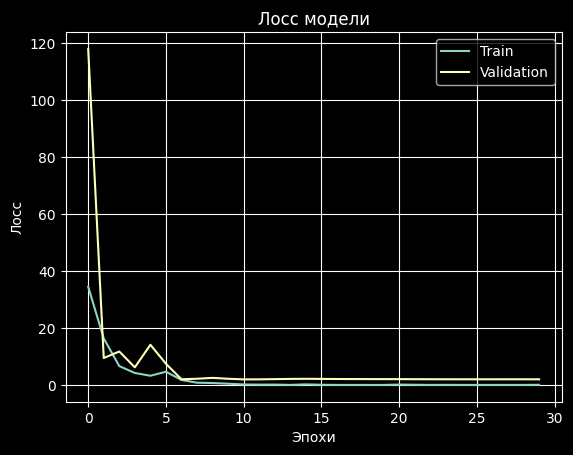

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Лосс модели')
plt.ylabel('Лосс')
plt.xlabel('Эпохи')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [19]:
def names(number):
    if number == 0:
        return 'Опухоль'
    else:
        return 'Норма'

99.99444484710693%, что это Норма


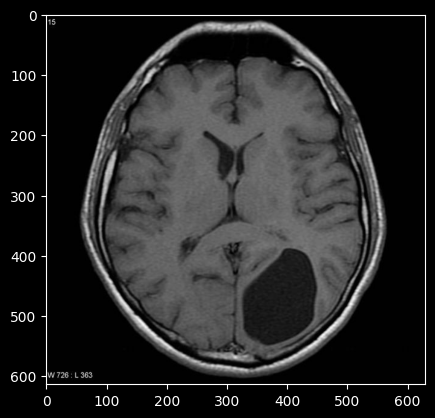

In [30]:
from PIL import Image
from matplotlib.pyplot import imshow


img = Image.open(r"Datasets/brain_tumor_dataset/no/N11.jpg")
img = img.convert("RGB")
x = np.array(img.resize((128, 128)))
x = x.reshape(1, 128, 128, 3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification] * 100) + '%, что это ' + names(classification))

99.93009567260742%, что это Опухоль


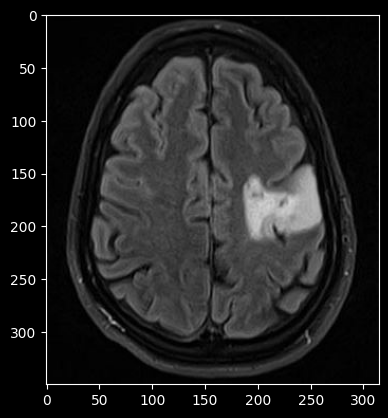

In [24]:
img = Image.open(r"Datasets/brain_tumor_dataset/yes/Y50.jpg")
img = img.convert("RGB")
x = np.array(img.resize((128, 128)))
x = x.reshape(1, 128, 128, 3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification] * 100) + '%, что это ' + names(classification))

## Accuracy, Precision, recall, и F1 мера

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes)
f1 = f1_score(y_true_classes, y_pred_classes)

print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

1/1 [==============================] - 0s 240ms/step
Accuracy: 0.8214
Precision: 0.8462
Recall: 0.7857
F1 Score: 0.8148
